## PCA and Text Analysis

This assignment involves processing real e-mails, some of which are scams.

Fair warning: Some of these scam e-mails have offensive content. If you start reading the e-mail text or the token data, you might read something offensive. If that's a problem, feel free to e-mail me, and we can talk about it and discuss how to proceed with alternative tasks.

### Q1.

**Tokens**: The individual words or symbols that create text data like emails. Natural Language Processing is primarily about analyzing the frequency and co-occurrence of tokens.

I aggregated all the emails into a single vector, and removed the punctuation and very common words (e.g. "the"). Run the below code chunk to open it, and use the Counter class to look at the most common words:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pickle
with open('/content/drive/MyDrive/DS 3001/All Tokens.pickle', 'rb') as file:
    all_tokens = pickle.load(file)

from collections import Counter
token_count = Counter(all_tokens)
token_freq = token_count.most_common()

Plot a histogram of the occurrences of tokens.

What do you notice about the frequency of occurrence of different tokens? How does it look?

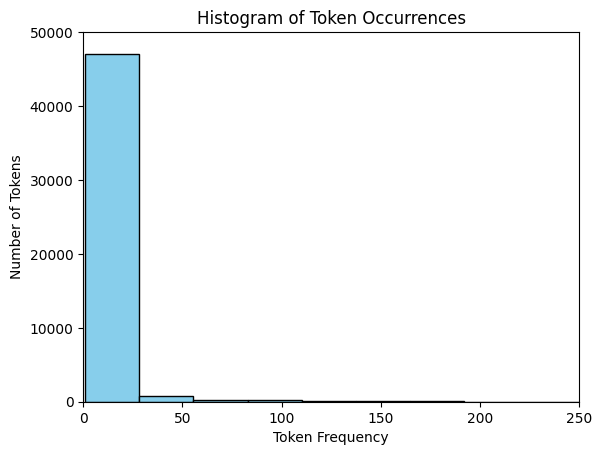

In [3]:
import matplotlib.pyplot as plt

counts = [count for token, count in token_freq]

plt.hist(counts, bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Token Frequency')
plt.ylabel('Number of Tokens')
plt.title('Histogram of Token Occurrences')
plt.xlim(0, 250)
plt.ylim(0, 50000)
plt.show()

What Do I Notice?



### Q2.

Load `Phishing_clean.parquet`. This is the text from the e-mails broken into the most common 2,711 tokens and one-hot-encoded as features/covariates. So each row is an e-mail, the `Email Type` takes the value 1 if it's a scam and 0 otherwise, and every other column is a word or symbol that occurs in at least 15 e-mails.

1. Perform an 80/20 train-test split of the data.
2. Run a regression of $y$ on the one-hot-encoded emails. What is the $R^2$ on the test set? On the training set?
3. What words have the largest coefficients in absolute value and most strongly influence predictions?

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score

Phishing = pd.read_parquet('/content/drive/MyDrive/DS 3001/Phishing Data.parquet')

X = Phishing.drop(columns=['Email Type'])
y = Phishing['Email Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LogisticRegression(max_iter=1000, solver='liblinear')
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("R² on training set:", round(r2_train, 4))
print("R² on test set:", round(r2_test, 4))


R² on training set: 0.8602
R² on test set: 0.7533


In [5]:
coef_df = pd.DataFrame({
    'token': X.columns,
    'coefficient': model.coef_[0]
})

coef_df['abs_value'] = coef_df['coefficient'].abs()

top_coef = coef_df.sort_values(by='abs_value', ascending=False)

print(top_coef.head(20))

         token  coefficient  abs_value
4        enron    -4.317310   4.317310
16        url:    -4.157278   4.157278
35       vince    -3.103588   3.103588
22      wrote:    -3.100601   3.100601
88      louise    -2.969376   2.969376
168  forwarded    -2.575830   2.575830
25    language    -2.524701   2.524701
103      wrote    -2.493791   2.493791
205      daren    -2.396262   2.396262
818       cnet    -2.285395   2.285395
192   mortgage     2.210906   2.210906
102    wrote:>    -2.172880   2.172880
30    attached    -2.150001   2.150001
44       click     2.106971   2.106971
412        pro     2.104196   2.104196
76         aug    -2.055126   2.055126
369      seems    -1.998369   1.998369
51      thanks    -1.989786   1.989786
113  september    -1.946283   1.946283
260       meds     1.907901   1.907901


### Q3.

Take the matrix of one-hot-encoded tokens (the data, less the outcome variable, `Email Type`) and perform a principal components analysis decomposition with two components. Plot the first two principal components in a scatter plot, and hue the points by whether they are a phishing scam or not. Do you notice any patterns?

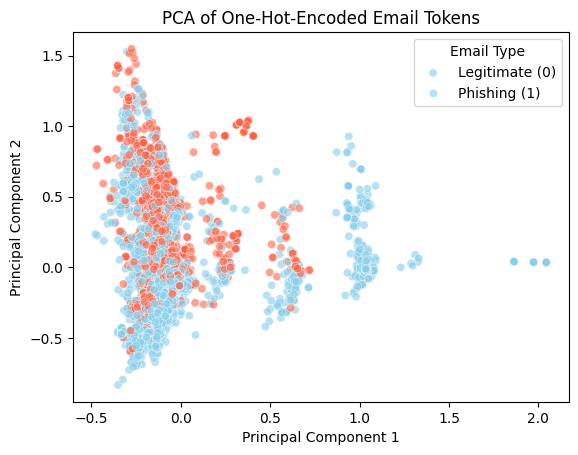

In [8]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

pca_df = pd.DataFrame({
    'PC1': X_pca[:, 0],
    'PC2': X_pca[:, 1],
    'Email Type': y
})

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Email Type', hue_order=[0,1], palette={0:'skyblue', 1:'tomato'}, alpha=0.6)
plt.legend(title='Email Type', labels=['Legitimate (0)', 'Phishing (1)'])
plt.title('PCA of One-Hot-Encoded Email Tokens')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()


What are the patterns?

### Q4.

Run a linear regression of $y$ on the first 2,610 principal components of $X$. What is the $R^2$ on the training and test sets? (I used cross validation to determine that 2,610 was approximately optimal, but not all 2,711 components.)

How does this performance compare to the linear regression?

In [10]:
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

pca = PCA(n_components=2610)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

reg = LinearRegression()
reg.fit(X_train_pca, y_train)

y_train_pred = reg.predict(X_train_pca)
y_test_pred = reg.predict(X_test_pca)

r2_train = r2_score(y_train, y_train_pred)
r2_test = r2_score(y_test, y_test_pred)

print("R² on Training Set:", round(r2_train, 4))
print("R² on Test Set:", round(r2_test, 4))

R² on Training Set: 0.7707
R² on Test Set: 0.645


What are the differences between this and the original linear regression?

### Q5.

Explain briefly in your own words what the advantage is in using the principal components to run this high-dimensional regression, rather than the original data.

Explain